Saving lstm_data_raw.xlsx to lstm_data_raw.xlsx
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3994
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0948 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0224
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0471
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0160
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0170
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0151
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0105
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0116
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0175
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0087
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0091
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

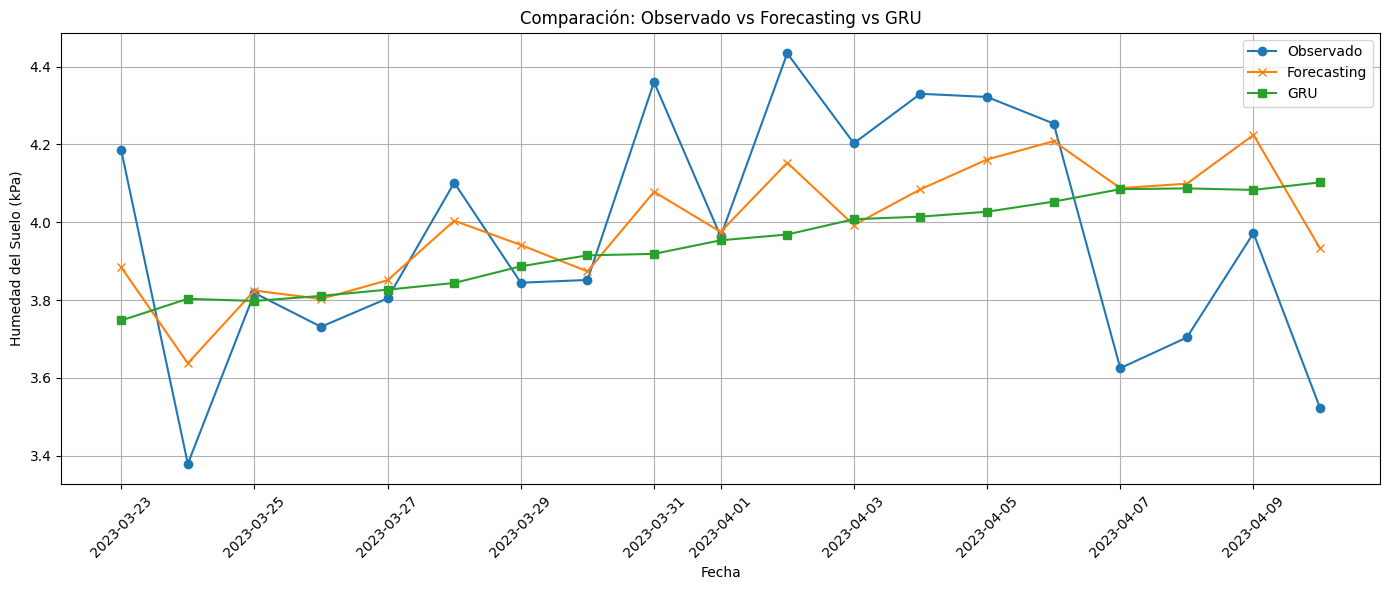

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from google.colab import files


uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_excel(filename)
df.columns = ['Fecha', 'Pronosticado', 'Observado']  # Asegura nombres estándar
df['Pronosticado'] = pd.to_numeric(df['Pronosticado'], errors='coerce')
df['Observado'] = pd.to_numeric(df['Observado'], errors='coerce')
df.dropna(inplace=True)


scaler = MinMaxScaler()
datos = df['Pronosticado'].values.reshape(-1, 1)
datos_esc = scaler.fit_transform(datos)


def crear_secuencias(data, pasos=10):
    X, y = [], []
    for i in range(pasos, len(data)):
        X.append(data[i - pasos:i])
        y.append(data[i])
    return np.array(X), np.array(y)

pasos = 10
X, y = crear_secuencias(datos_esc, pasos)


split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X.shape[1], 1)),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)


pred = model.predict(X_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(y_test)


observado = df['Observado'].values.reshape(-1, 1)[-len(pred_inv):]
forecasting = df['Pronosticado'].values.reshape(-1, 1)[-len(pred_inv):]
fechas = df['Fecha'].values[-len(pred_inv):]


print("== Forecasting vs Observado ==")
print(f"MSE: {mean_squared_error(observado, forecasting):.4f}")
print(f"MAE: {mean_absolute_error(observado, forecasting):.4f}")
print(f"R²: {r2_score(observado, forecasting):.4f}")

print("\n== GRU vs Observado ==")
print(f"MSE: {mean_squared_error(observado, pred_inv):.4f}")
print(f"MAE: {mean_absolute_error(observado, pred_inv):.4f}")
print(f"R²: {r2_score(observado, pred_inv):.4f}")


comparacion_df = pd.DataFrame({
    'Fecha': fechas,
    'Observado': observado.flatten(),
    'Forecasting (original)': forecasting.flatten(),
    'Predicción GRU': pred_inv.flatten(),
    'Error Forecast': np.abs(observado.flatten() - forecasting.flatten()),
    'Error GRU': np.abs(observado.flatten() - pred_inv.flatten())
})


plt.figure(figsize=(14, 6))
plt.plot(comparacion_df['Fecha'], comparacion_df['Observado'], label='Observado', marker='o')
plt.plot(comparacion_df['Fecha'], comparacion_df['Forecasting (original)'], label='Forecasting', marker='x')
plt.plot(comparacion_df['Fecha'], comparacion_df['Predicción GRU'], label='GRU', marker='s')
plt.xlabel("Fecha")
plt.ylabel("Humedad del Suelo (kPa)")
plt.title("Comparación: Observado vs Forecasting vs GRU")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("comparacion_3_series.png")
plt.show()


comparacion_df.to_excel("comparacion_3_columnas.xlsx", index=False)
files.download("comparacion_3_columnas.xlsx")


model.save("modelo_gru_entrenado.h5")
files.download("modelo_gru_entrenado.h5")





/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2691
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0639
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0251
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0078
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0139
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0087
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━

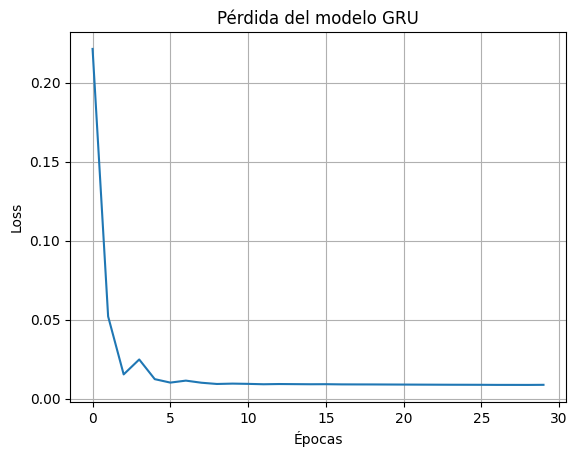

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


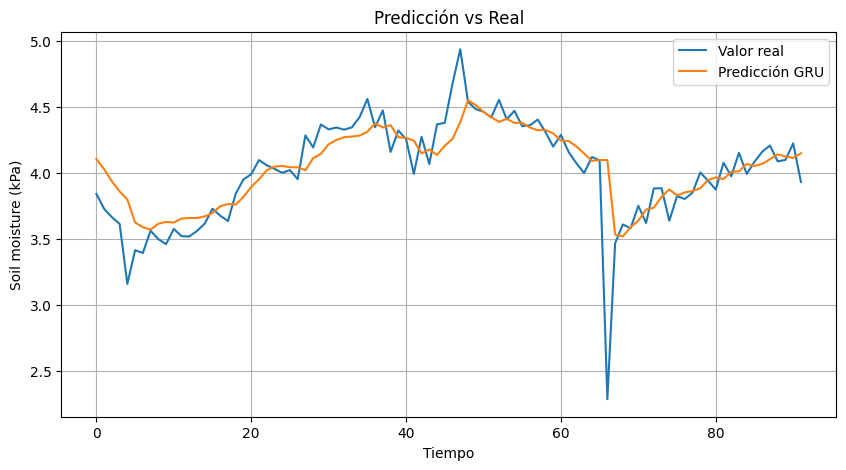

Error cuadrático medio (MSE): 0.0607
Error absoluto medio (MAE): 0.1337


TypeError: '<' not supported between instances of 'datetime.datetime' and 'str'

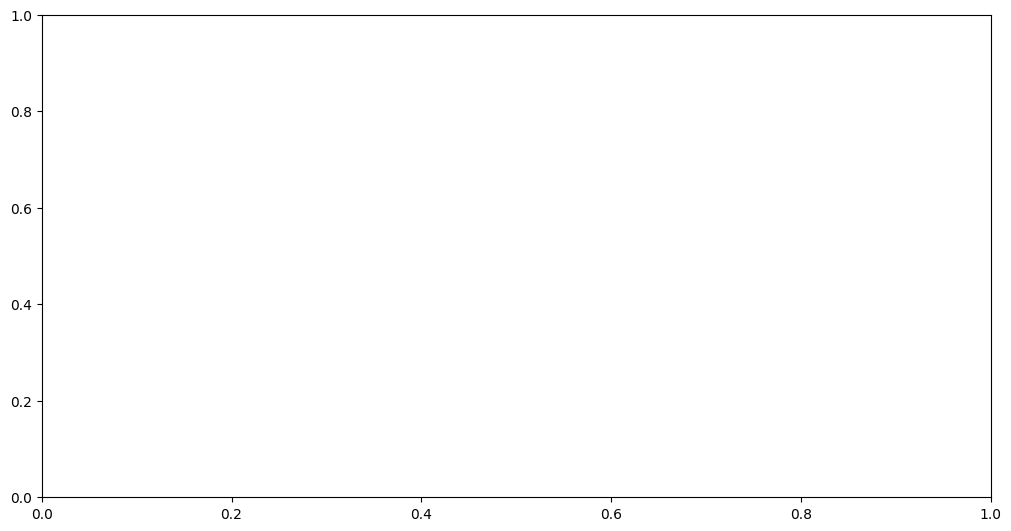

In [ ]:
# @title DATE vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['DATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'DATE'}, axis=1)
              .sort_values('DATE', ascending=True))
  xs = counted['DATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('DATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE')
_ = plt.ylabel('count()')